In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input, Attention, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Load the dataset
df = pd.read_csv("dataset.csv")

# Ensure the 'id' column is datetime and set as index
df['timestamp'] = pd.to_datetime(df['id'], errors='coerce')
df.set_index('timestamp', inplace=True)

# Drop rows with invalid dates
df.dropna(subset=['id'], inplace=True)

# Columns for training
cols = ["ws100", "humid", "wdisp100"]
df_for_training = df[cols].astype(float)

# Drop rows with NaN values
df_for_training.dropna(inplace=True)

# Scaling with MinMaxScaler
scaler = MinMaxScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)

# Define sequence and prediction lengths
sequence_length = 48  # Last 36 hours (36 * 6 values)
prediction_length = 6  # Next 1 hour (6 values)

X, y = [], []

In [49]:
# Prepare sequences for input and output
for i in range(len(df_for_training_scaled) - sequence_length - prediction_length + 1):
    X.append(df_for_training_scaled[i: i + sequence_length])
    y.append(df_for_training_scaled[i + sequence_length: i + sequence_length + prediction_length, :])

X = np.array(X)
y = np.array(y)

print(f"Shape of X: {X.shape}")  # (samples, 30, features)
print(f"Shape of y: {y.shape}")  # (samples, 6, features)

Shape of X: (7508, 48, 3)
Shape of y: (7508, 6, 3)


In [50]:
# Manual train-test-validation split
train_size = int(len(X) * 0.9)
val_size = int(train_size * 0.1)

X_train = X[:train_size - val_size]
y_train = y[:train_size - val_size]
X_val = X[train_size - val_size:train_size]
y_val = y[train_size - val_size:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (6082, 48, 3), (6082, 6, 3)
Validation set shape: (675, 48, 3), (675, 6, 3)
Test set shape: (751, 48, 3), (751, 6, 3)


In [51]:
def custom_loss(y_true, y_pred):
    # Extract the 'ws100' component at the sixth time step (index 5)
    ws100_index = cols.index('ws100')
    y_true_ws100_sixth = y_true[:, 5, ws100_index]  # Shape: [batch_size]
    y_pred_ws100_sixth = y_pred[:, 5, ws100_index]  # Shape: [batch_size]

    # Compute MSE for 'ws100' at the sixth time step
    mse_ws100_sixth = tf.square(y_true_ws100_sixth - y_pred_ws100_sixth)  # Shape: [batch_size]

    # Compute additional weight for 'ws100' near 7 m/s
    threshold = 4.0
    delta = 1.0  # Define a range around the threshold
    condition = tf.abs(y_true_ws100_sixth - threshold) <= delta  # Shape: [batch_size]
    weight_ws100 = tf.where(
        condition,
        tf.constant(2.0),  # Increase the loss weight
        tf.constant(1.0)
    )  # Shape: [batch_size]

    # Apply weight to 'ws100' MSE
    weighted_mse_ws100 = mse_ws100_sixth * weight_ws100  # Shape: [batch_size]

    # Compute the mean loss over the batch
    loss = tf.reduce_mean(weighted_mse_ws100)

    return loss

In [52]:
def build_model(hp):
    # Hyperparameters to tune
    units = hp.Int('units', min_value=128, max_value=512, step=128)
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    num_layers = hp.Int('num_layers', min_value=4, max_value=6, step=1)
    activation = hp.Choice('activation', ['relu', 'tanh'])
    
    # Encoder
    encoder_inputs = Input(shape=(sequence_length, X.shape[2]))
    encoder_outputs = encoder_inputs
    for i in range(num_layers):
        # Add LSTM layer
        encoder_lstm = LSTM(
            units=units,
            return_sequences=True,  # Return sequences for attention mechanism
            return_state=True,
            activation=activation
        )
        # Get outputs and states
        encoder_outputs, state_h, state_c = encoder_lstm(encoder_outputs)
        # Apply dropout
        encoder_outputs = Dropout(dropout_rate)(encoder_outputs)
    # Capture the last encoder states
    encoder_states = [state_h, state_c]

    # Decoder
    # Use the last hidden state as the initial input to the decoder
    decoder_inputs = RepeatVector(prediction_length)(state_h)
    decoder_outputs = decoder_inputs
    for i in range(num_layers):
        # Add LSTM layer
        decoder_lstm = LSTM(
            units=units,
            return_sequences=True,
            activation=activation
        )
        # For the first decoder layer, initialize with encoder states
        if i == 0:
            decoder_outputs = decoder_lstm(decoder_outputs, initial_state=encoder_states)
        else:
            decoder_outputs = decoder_lstm(decoder_outputs)
        # Apply dropout
        decoder_outputs = Dropout(dropout_rate)(decoder_outputs)

    # Attention layer
    attention_outputs = Attention()([decoder_outputs, encoder_outputs])

    # Concatenate decoder outputs with attention outputs
    decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_outputs])

    # Final TimeDistributed layer to generate outputs
    outputs = TimeDistributed(Dense(len(cols), activation='linear'))(decoder_concat_input)

    # Define the model
    model = Model(inputs=encoder_inputs, outputs=outputs)

    # Compile the model with optimizer and custom loss function
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=custom_loss
    )

    return model

In [53]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=1,  # Increased from 1 to 10
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='wind_speed_prediction'
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=7,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

Trial 1 Complete [00h 18m 54s]
val_loss: 0.006068081129342318

Best val_loss So Far: 0.006068081129342318
Total elapsed time: 00h 18m 54s


In [ ]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

# Build and train the best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

model.summary()

Best hyperparameters: {'units': 256, 'learning_rate': 0.001, 'dropout_rate': 0.30000000000000004, 'num_layers': 4, 'activation': 'relu'}
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 152s 699ms/step - loss: 0.0499 - val_loss: 0.0122
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 169s 885ms/step - loss: 0.0142 - val_loss: 0.0101
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 159s 835ms/step - loss: 0.0133 - val_loss: 0.0138
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 150s 784ms/step - loss: 38964105216.0000 - val_loss: 0.0127
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 143s 752ms/step - loss: 0.0220 - val_loss: 0.0105
Epoch 6/10
 19/191 ━━━━━━━━━━━━━━━━━━━━ 2:25 843ms/step - loss: 0.0197

In [26]:
# Final evaluation on the test set
y_pred = model.predict(X_test)

# Inverse transform y_pred
y_pred_flat = y_pred.reshape(-1, len(cols))
y_pred_orig = scaler.inverse_transform(y_pred_flat)
y_pred_orig = y_pred_orig.reshape(-1, prediction_length, len(cols))

# Inverse transform y_test
y_test_flat = y_test.reshape(-1, len(cols))
y_test_orig = scaler.inverse_transform(y_test_flat)
y_test_orig = y_test_orig.reshape(-1, prediction_length, len(cols))

24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 635ms/step


Evaluation for time step 1
'ws100': RMSE = 1.5068, NRMSE = 0.2181, Relative Error = 19.01%


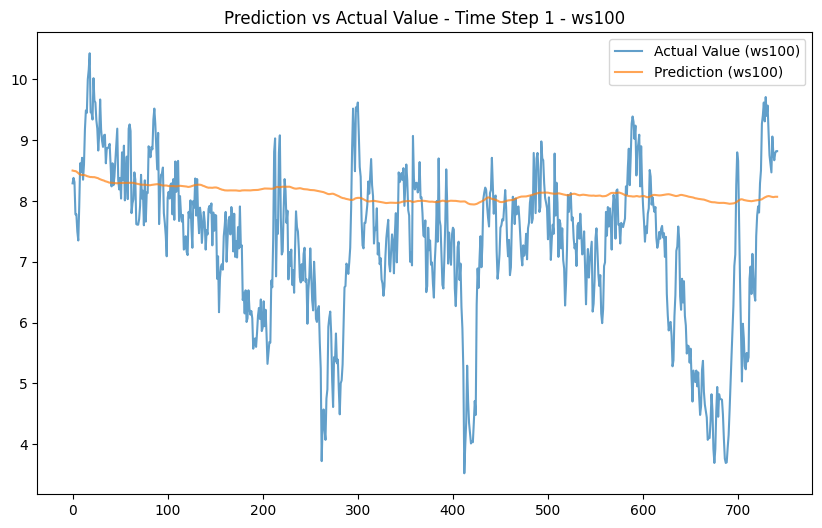

'humid': RMSE = 26.0672, NRMSE = 0.6860, Relative Error = 31.89%


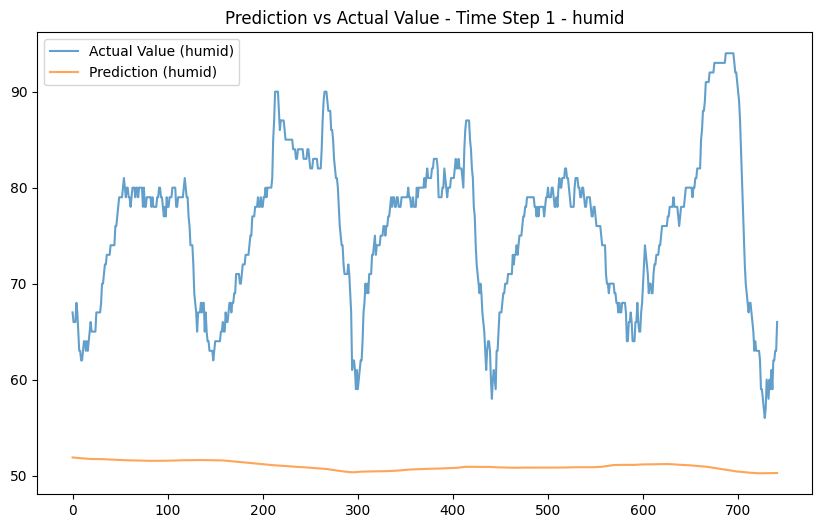

'wdisp100': RMSE = 0.8847, NRMSE = 0.5820, Relative Error = 100.65%


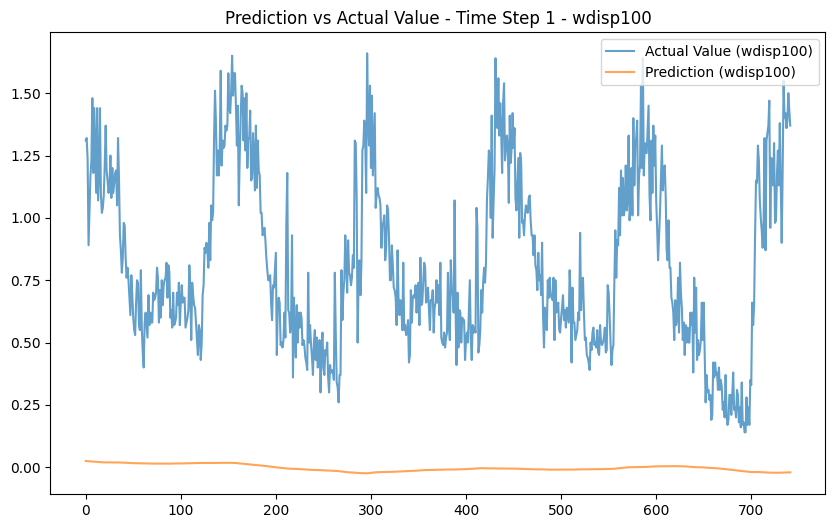

Evaluation for time step 2
'ws100': RMSE = 1.5511, NRMSE = 0.2245, Relative Error = 19.93%


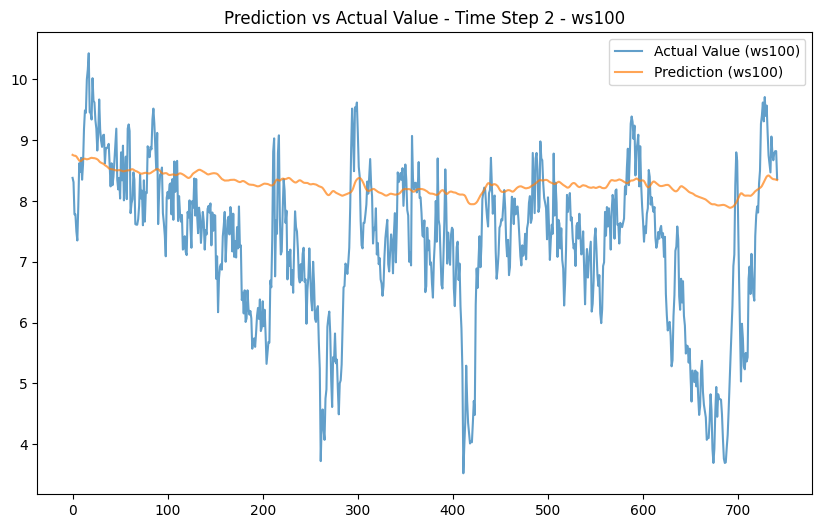

'humid': RMSE = 26.1602, NRMSE = 0.6884, Relative Error = 32.02%


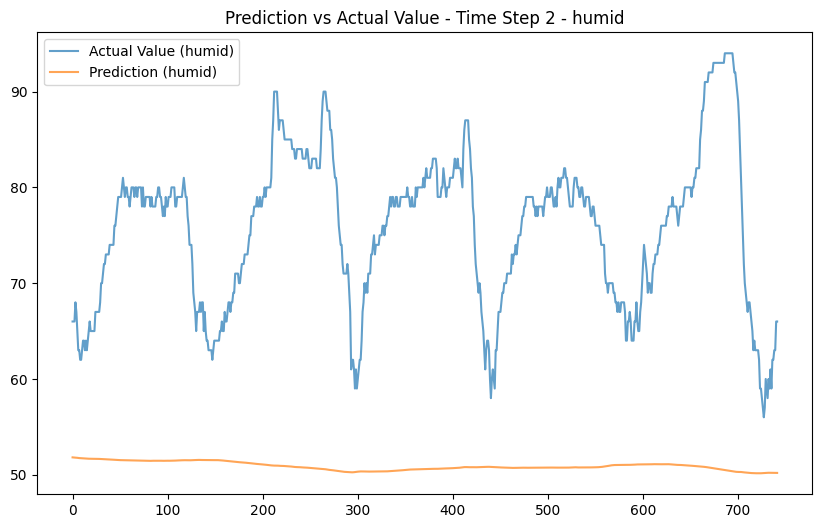

'wdisp100': RMSE = 0.8855, NRMSE = 0.5826, Relative Error = 100.68%


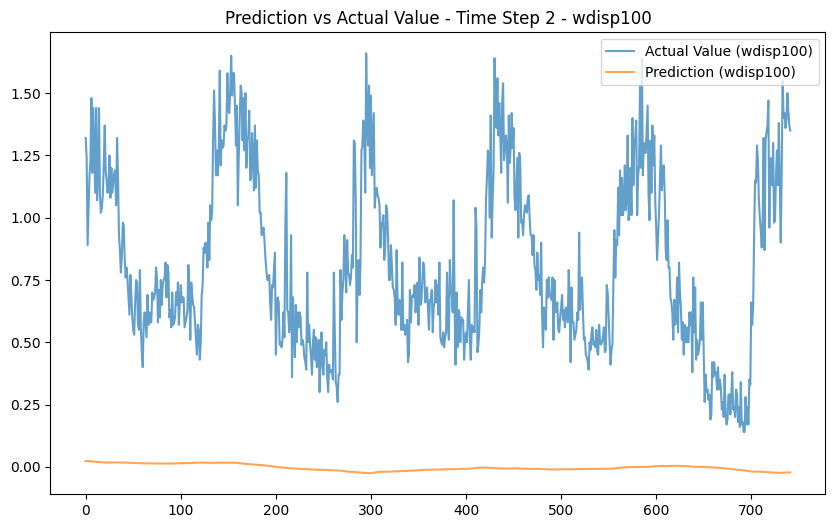

Evaluation for time step 3
'ws100': RMSE = 1.4858, NRMSE = 0.2150, Relative Error = 19.25%


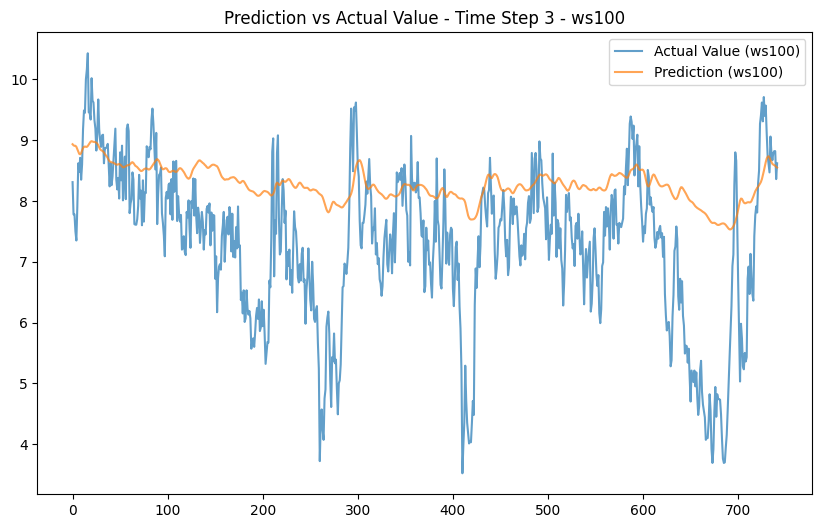

'humid': RMSE = 26.2539, NRMSE = 0.6909, Relative Error = 32.14%


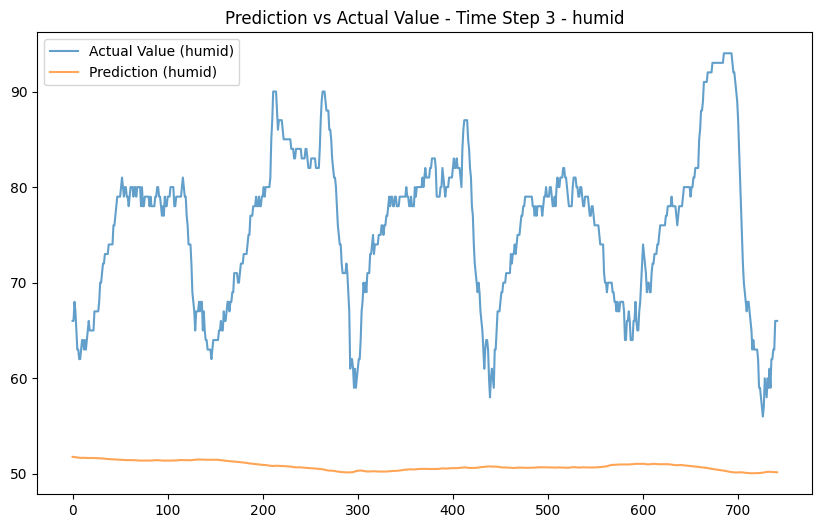

'wdisp100': RMSE = 0.8841, NRMSE = 0.5816, Relative Error = 100.40%


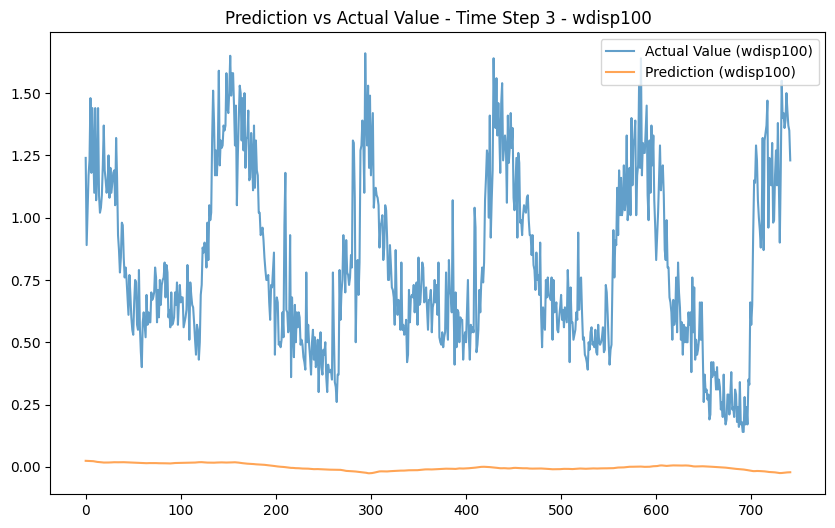

Evaluation for time step 4
'ws100': RMSE = 1.3400, NRMSE = 0.1939, Relative Error = 17.33%


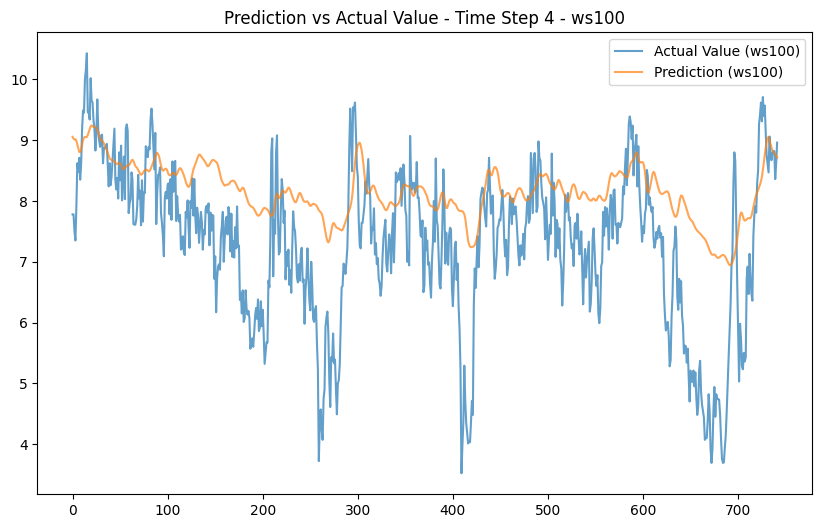

'humid': RMSE = 26.3591, NRMSE = 0.6937, Relative Error = 32.26%


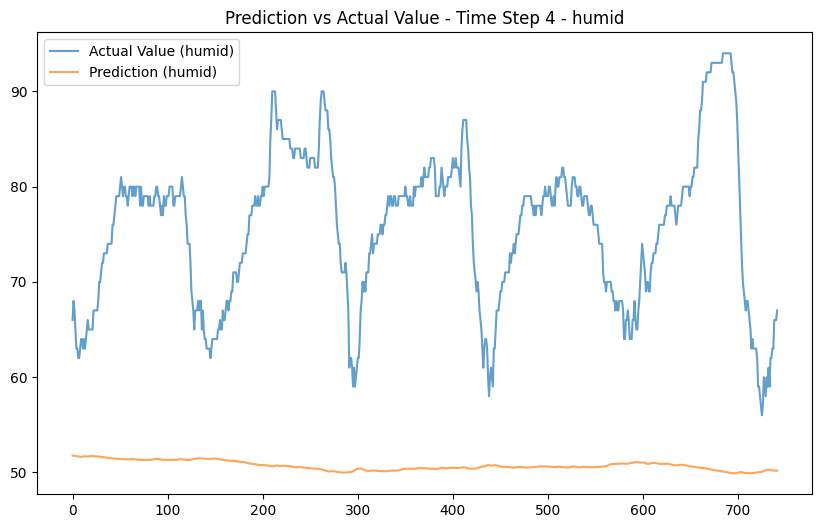

'wdisp100': RMSE = 0.8824, NRMSE = 0.5805, Relative Error = 100.10%


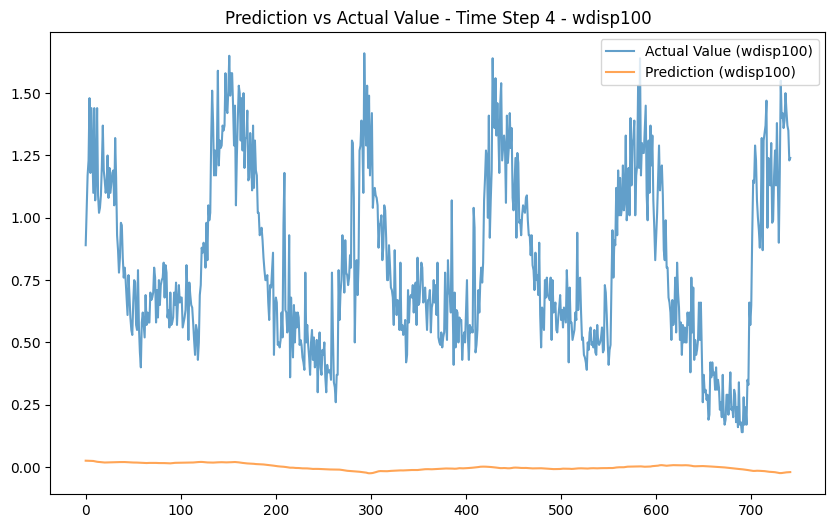

Evaluation for time step 5
'ws100': RMSE = 1.1657, NRMSE = 0.1687, Relative Error = 14.88%


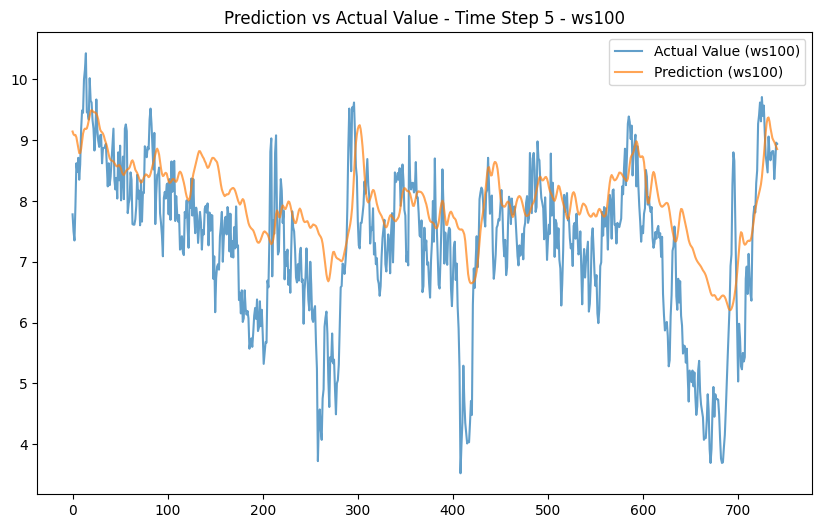

'humid': RMSE = 26.4802, NRMSE = 0.6968, Relative Error = 32.40%


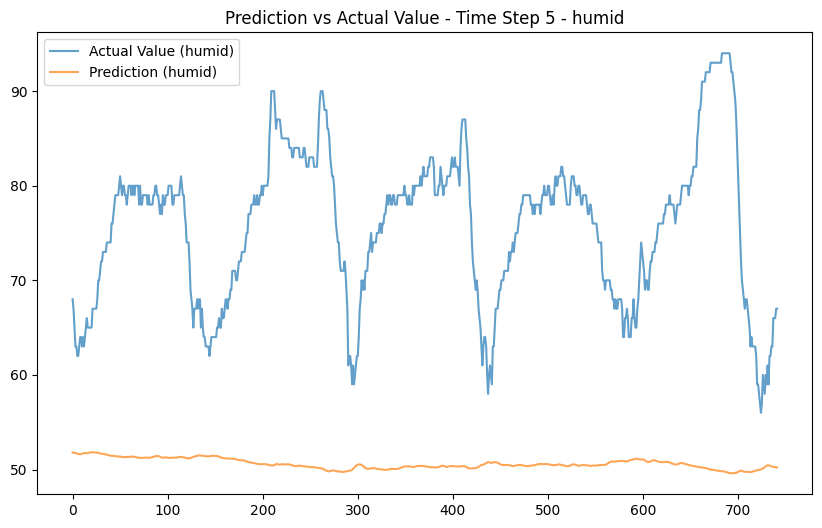

'wdisp100': RMSE = 0.8819, NRMSE = 0.5802, Relative Error = 100.01%


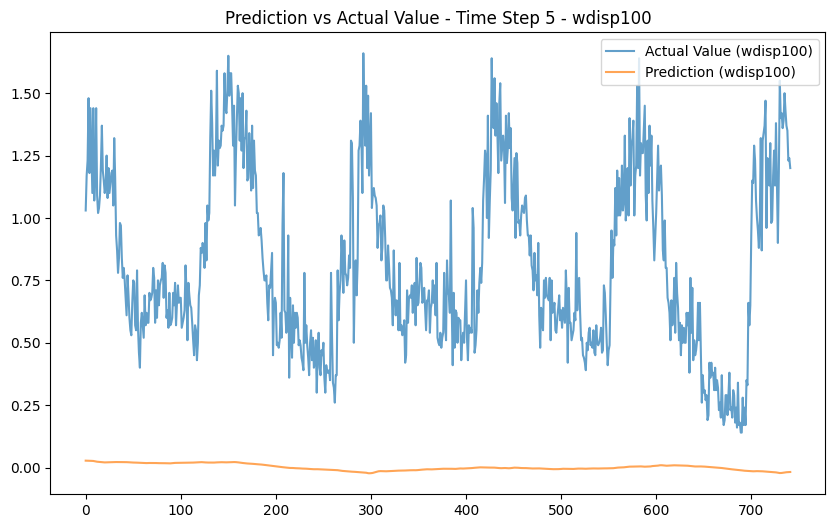

Evaluation for time step 6
'ws100': RMSE = 1.0317, NRMSE = 0.1493, Relative Error = 12.83%


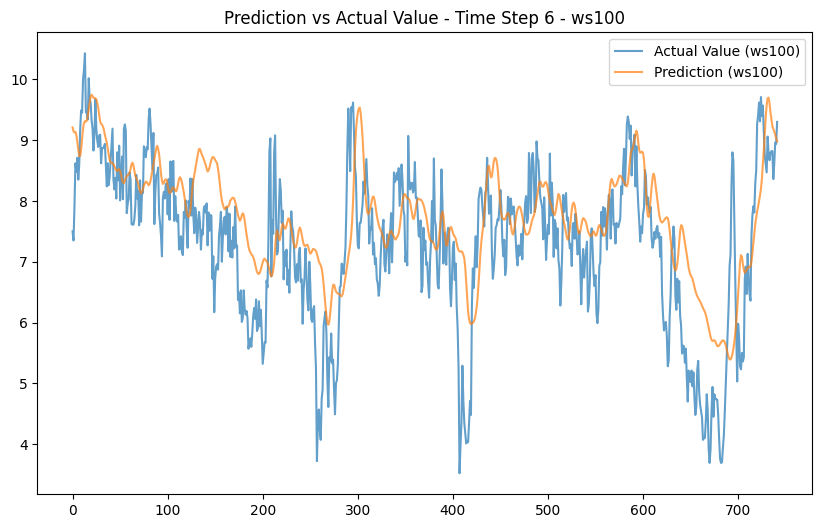

'humid': RMSE = 26.6158, NRMSE = 0.7004, Relative Error = 32.55%


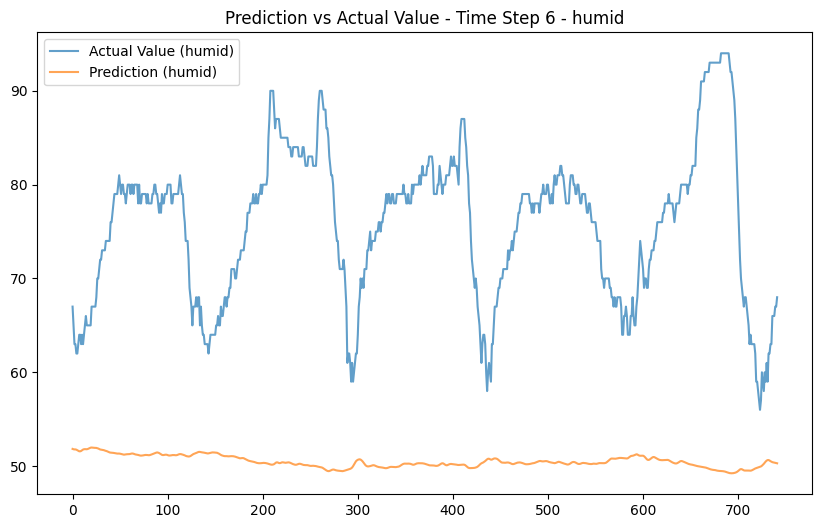

'wdisp100': RMSE = 0.8820, NRMSE = 0.5803, Relative Error = 100.23%


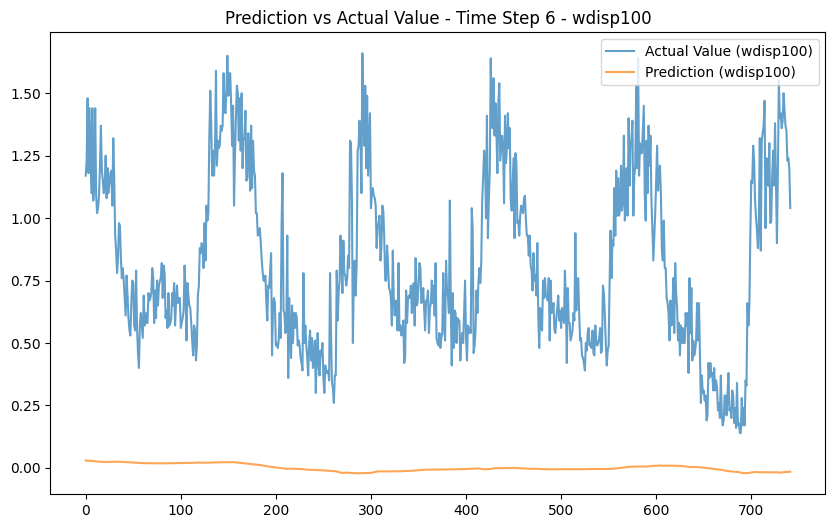

In [27]:
# Evaluate all predicted time steps
for t in range(prediction_length):
    print(f"Evaluation for time step {t+1}")
    for i, col in enumerate(cols):
        y_true = y_test_orig[:, t, i]
        y_pred_col = y_pred_orig[:, t, i]

        rmse = np.sqrt(np.mean((y_true - y_pred_col) ** 2))
        nrmse = rmse / (y_true.max() - y_true.min())
        relative_error = (np.mean(np.abs((y_true - y_pred_col) / y_true)) * 100)

        print(f"'{col}': RMSE = {rmse:.4f}, NRMSE = {nrmse:.4f}, Relative Error = {relative_error:.2f}%")

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(y_true, label=f"Actual Value ({col})", alpha=0.7)
        plt.plot(y_pred_col, label=f"Prediction ({col})", alpha=0.7)
        plt.legend()
        plt.title(f"Prediction vs Actual Value - Time Step {t+1} - {col}")
        plt.show()